<a href="https://colab.research.google.com/github/Krittika91/Deep-Learning-HW/blob/main/MIS_285_HW_2_aw39578_kd29275_dg38354.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MIS 285N Homework 2
**Due: Monday, February 5, 11:59 pm**

Team Members:
Avi Walyat aw39578
Krittika Deshwal kd29275
Davis Gill dg38354

Notebook Link - https://colab.research.google.com/drive/1Gi2YrKT_mDP8Wz-99OomgIK5pBsEssmy?usp=sharing

Submit:

A pdf of your notebook with solutions.
A link to your colab notebook or also upload your .ipynb if not working on colab.

# Goals of this Homework

There are a number of goals of this notebook:

1.   Learning to put together a basic model beyond what we did in the previous notebook. Main emphasis: new layers, including convolution and max pooling.
2.   Learning the basics of training.
3.   Learning basics of loading data and visualizing.
4.   Learning the basics of printing out a model.

Also useful to see
https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html



<img src="https://miro.medium.com/max/2510/1*vkQ0hXDaQv57sALXAJquxA.jpeg" width=1024px/>

In [ ]:
import torchvision
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.nn.functional as F


classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

batch_size = 4

# the tutorial calls the dataloader twice -- this code defines a function
# that will do this for the train/test data.

def fetch_dataloader(batch_size, transform=None, is_train=True):
    """
    We saw the data loaders in the previous hw.
    This creates a method for us to get (image, label) pairs.
    We can use it so that we do not have to load everything into memory
    at once.
    """
    data = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

    # Custom train/val split.
    indices = [i for i in range(len(data)) if (i%10 > 0) == is_train]

    data = torch.utils.data.Subset(data, indices)
    loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True, num_workers=2)
    return loader


train_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

val_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

data_train = fetch_dataloader(batch_size, train_transform, is_train=True)
data_val = fetch_dataloader(batch_size, val_transform, is_train=False)

100%|██████████| 170498071/170498071 [00:04<00:00, 42315302.48it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## Problem 1 (nothing to turn in)

Read about transforms. These are routinely used when loading images. We've used a particular set of parameters. But you will see many other choices.

https://pytorch.org/vision/stable/transforms.html


## Problem 2

Figure out how to use the data loader to display the data.
For example, you could look here

https://towardsdatascience.com/beginners-guide-to-loading-image-data-with-pytorch-289c60b7afec
and then https://stackoverflow.com/questions/51756581/how-do-i-turn-a-pytorch-dataloader-into-a-numpy-array-to-display-image-data-with

or you could look at the pytorch CIFAR10 tutorial

https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

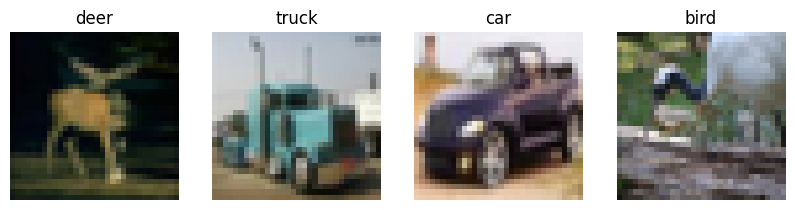

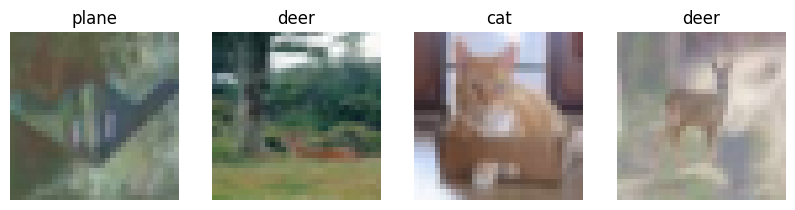

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Function to display images with labels
def imshow_with_labels(images, labels):
    plt.figure(figsize=(10, 4))
    for i in range(len(images)):
        plt.subplot(1, len(images), i + 1)
        plt.title(classes[labels[i]])
        img = images[i] / 2 + 0.5  # unnormalize
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.axis('off')
    plt.show()

# Define the function to display images
def imshow(img):
    img = img / 2 + 0.5     # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(data_train)
images, labels = next(dataiter)  # Use next() to get the next batch

# Show images with labels
imshow_with_labels(images, labels)

# Similarly, you can display validation data
dataiter_val = iter(data_val)
images_val, labels_val = next(dataiter_val)  # Use next() to get the next batch

# Show images with labels
imshow_with_labels(images_val, labels_val)


## Model Implementation.

Now it is time to implement our CNN. You will recognize syntax from the previous HW. However, whereas in the last homework we had only fully connected layers and ReLU layers, here we will use more options. In addition to fully connected and ReLU layers, we want to use:

* Convolutional layers: `torch.nn.Conv2d`
* Max Pooling Layers:`torch.nn.MaxPool2d`
* Average Pooling Layers: `torch.nn.AvgPool2d`

Fully connected layers primarily had 3 parameters: input size, output size, and bias.

Convolutional layers have many more parameters, as we discussed in class, In particular, recall:

* kernel_size
* stride
* padding
* dilation

Read about these in the Pytorch documentation:

https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html


Next we see some basic code, similar in spirit to our previous colab notebook, but, critically, adding a new type of layer: a convolutional layer.

In [ ]:
# We define two different models, using different syntax.
# CNNClassifier is basic code borrowed from Phil Krahenbuhl
# ConvNet comes from the pytorch tutorial linked above.
#

class CNNClassifier(torch.nn.Module):
    def __init__(self, input_channels, num_classes):
        """
        Define the layer(s) needed for the model.
        Feel free to define additional input arguments.
        """
        super().__init__()
        self.conv = nn.Conv2d(input_channels, 16, 7, 2, 3)
        self.cls = nn.Linear(16, num_classes)
        self.ReLU = nn.ReLU()
        # or could do
        # self.CNN = nn.Sequential(torch.nn.Conv2d(input_channels, 16, 7, 2, 3), torch.nn.ReLU(),torch.nn.Linear(16, num_classes))

    def forward(self, x):
        """
        Calculate the classification score (logits).

        Input:
            x (float tensor N x 3 x 32 x 32): input images
        Output:
            y (float tensor N x 10): classification scores (logits) for each class
        """
        x = self.conv(x)

        # Add a ReLU
        x = self.ReLU(x)
        # Add global average pooling
        x = x.mean(dim=(2,3))
        return self.cls(x)

    def predict(self, image):
        return self(image).argmax(1)

# From the pytorch tutorial linked above.
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

# We can rewrite it equivalently this way
class ConvNet2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# This way is also equivalent
class ConvNet3(nn.Module):
    def __init__(self):
        super().__init__()
        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## Model Training and Validation


In [ ]:
# Best to use a GPU: change your runtime and select the free GPU
# Then we need to load our data onto whatever compute element we're using.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# Now we train the first model.
#


# Choose a model to train
model = CNNClassifier(3, 10)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.train()


for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(data_train, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.225
[1,  4000] loss: 2.098
[1,  6000] loss: 2.041
[1,  8000] loss: 2.023
[1, 10000] loss: 1.987
[2,  2000] loss: 1.931
[2,  4000] loss: 1.905
[2,  6000] loss: 1.894
[2,  8000] loss: 1.850
[2, 10000] loss: 1.820
[3,  2000] loss: 1.800
[3,  4000] loss: 1.804
[3,  6000] loss: 1.792
[3,  8000] loss: 1.790
[3, 10000] loss: 1.768
[4,  2000] loss: 1.777
[4,  4000] loss: 1.764
[4,  6000] loss: 1.759
[4,  8000] loss: 1.759
[4, 10000] loss: 1.748
[5,  2000] loss: 1.756
[5,  4000] loss: 1.748
[5,  6000] loss: 1.737
[5,  8000] loss: 1.753
[5, 10000] loss: 1.727
Finished Training


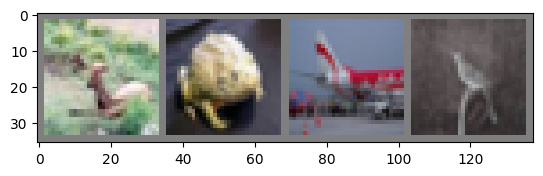

GroundTruth:   deer  frog plane  bird
Predicted:    dog plane  frog   car


In [ ]:
# Let's see how well this trained model performs on a couple data points.
dataiter = iter(data_val)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
images, labels = images.to(device), labels.to(device)

# and now what our model thinks
output = model(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

## Problem 3

Use your validation data loader (data_val) to assess the accuracy on the entire data set.

If you did this correctly, you should find that your accuracy is somewhere in the 30-40% range -- not great, but a lot better than guessing, and much better than we were able to do with trees.  

In [ ]:
correct = 0
total = 0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

with torch.no_grad():  # Disable gradient calculation
    for images, labels in data_val:
        images, labels = images.to(device), labels.to(device)  # Move data to the same device as the model
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)  # Get the index of the maximum output
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print('Accuracy on the validation dataset: {:.2f}%'.format(100 * accuracy))


Accuracy on the validation dataset: 34.54%


# Time to train the deeper model

In [ ]:
# Now we train the second model. We see that it does quite a bit better than the first.
#
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Choose a model to train
model2 = ConvNet() # note that this command resets the parameters
model2.to(device)
model2.train()

# Set the loss function and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model2.parameters(), lr=0.001, momentum=0.9)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')




In [ ]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(data_train, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model2(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.210
[1,  4000] loss: 1.877
[1,  6000] loss: 1.683
[1,  8000] loss: 1.598
[1, 10000] loss: 1.555
[2,  2000] loss: 1.457
[2,  4000] loss: 1.399
[2,  6000] loss: 1.371
[2,  8000] loss: 1.371
[2, 10000] loss: 1.320
Finished Training


## Problem 4

Repeat what you did for Problem 3 above: use your validation data loader (data_val) to assess the accuracy on the entire data set.

If you did this correctly, you should find that your accuracy is somewhere in the 50-60% range. Far from perfect, but still better than how we did above.

In [ ]:
correct = 0
total = 0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

with torch.no_grad():  # Disable gradient calculation
    for images, labels in data_val:
        images, labels = images.to(device), labels.to(device)  # Move data to the same device as the model
        outputs = model2(images)
        _, predicted = torch.max(outputs.data, 1)  # Get the index of the maximum output
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print('Accuracy on the validation dataset for Model 2: {:.2f}%'.format(100 * accuracy))


Accuracy on the validation dataset for Model 2: 53.34%


## Problem 5

How many parameters does your model have? You can either compute by hand, or much better, use the summary command from torchsummary
```
from torchsummary import summary
```
Note that you'll have to figure out how to use use, and also you will have to enter the size of your input.

Also try using the command

```
for name, layer in model2.named_modules():
    print(name,layer)
```
This one is very useful when we want to download someone else's netework, and we need to know what the names of the layers are.

In [ ]:
from torchsummary import summary

summary(model2, input_size=(3, 32, 32))  # Input size for CIFAR-10 dataset (3 channels, 32x32 images)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
              ReLU-2            [-1, 6, 28, 28]               0
         MaxPool2d-3            [-1, 6, 14, 14]               0
            Conv2d-4           [-1, 16, 10, 10]           2,416
              ReLU-5           [-1, 16, 10, 10]               0
         MaxPool2d-6             [-1, 16, 5, 5]               0
            Linear-7                  [-1, 120]          48,120
              ReLU-8                  [-1, 120]               0
            Linear-9                   [-1, 84]          10,164
             ReLU-10                   [-1, 84]               0
           Linear-11                   [-1, 10]             850
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/ba

In [ ]:
for name, layer in model2.named_modules():
    print(name, layer)

 ConvNet(
  (relu): ReLU()
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
relu ReLU()
conv1 Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
pool MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
conv2 Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
fc1 Linear(in_features=400, out_features=120, bias=True)
fc2 Linear(in_features=120, out_features=84, bias=True)
fc3 Linear(in_features=84, out_features=10, bias=True)


## Problem 6

How much can you decrease the error? Try to make your own convolutional neural network for CIFAR-10. Don't make it so big that you can't train it on Colab! You can play around with the parameters of the network and also with the parameters of training (train for longer -- more epochs, possibly using other parameters for step size, momentum, etc.).

**We will give 20 lab bonus points to the team with the best accuracy.**

In [ ]:
from tensorflow.keras.datasets import cifar10

import numpy as np
import pandas as pd

import pickle

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import utils

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPooling2D, GlobalAveragePooling2D, Activation, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print('Training set shape:', X_train.shape)
print('Test set shape:', X_test.shape)

170498071/170498071 [==============================] - 2s 0us/step
Training set shape: (50000, 32, 32, 3)
Test set shape: (10000, 32, 32, 3)


In [ ]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train = X_train / 255.0
X_test = X_test / 255.0

In [ ]:
num_classes = 10

In [ ]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

In [ ]:
def cnn_model():

    model = Sequential()

    # First Conv layer
    model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-4), input_shape=(32,32,3)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.3))

    # Second Conv layer
    model.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-4)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.3))

    # Third, fourth, fifth convolution layer
    model.add(Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-4)))
    model.add(Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-4)))
    model.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-4)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.3))

    # Fully Connected layers
    model.add(Flatten())

    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(10, activation='softmax'))

    model.summary()

    return model

In [ ]:
datagen = ImageDataGenerator(featurewise_center=False,
                            samplewise_center=False,
                            featurewise_std_normalization=False,
                            samplewise_std_normalization=False,
                            zca_whitening=False,
                            rotation_range=15,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            horizontal_flip=True,
                            vertical_flip=False)

datagen.fit(X_train)

In [ ]:
model = cnn_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 128)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 16, 16, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 256)       295168    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 256)         0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 8, 8, 256)         0

In [ ]:
import tensorflow as tf
from keras.optimizers import Adam
from keras.optimizers.schedules import ExponentialDecay

# Define the initial learning rate
initial_learning_rate = 0.0003

# Define the decay rate
decay_rate = 0.95

# Define the decay steps
decay_steps = 1000

# Create a learning rate schedule with exponential decay
lr_schedule = ExponentialDecay(
    initial_learning_rate,
    decay_steps=decay_steps,
    decay_rate=decay_rate,
    staircase=False)

# Create the Adam optimizer with the learning rate schedule
optimizer = Adam(learning_rate=lr_schedule)

# Compile the model with the optimizer
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])


In [ ]:
history = model.fit(datagen.flow(X_train, y_train, batch_size = 64),
                    steps_per_epoch = len(X_train) // 64,
                    epochs = 50,
                    validation_data= (X_valid, y_valid),
                    verbose=1)

Epoch 1/50
625/625 [==============================] - 38s 48ms/step - loss: 2.1530 - accuracy: 0.1960 - val_loss: 1.7784 - val_accuracy: 0.3365
Epoch 2/50
625/625 [==============================] - 31s 49ms/step - loss: 1.7401 - accuracy: 0.3466 - val_loss: 1.5241 - val_accuracy: 0.4318
Epoch 3/50
625/625 [==============================] - 30s 48ms/step - loss: 1.5338 - accuracy: 0.4423 - val_loss: 1.3407 - val_accuracy: 0.5212
Epoch 4/50
625/625 [==============================] - 28s 45ms/step - loss: 1.4004 - accuracy: 0.5082 - val_loss: 1.1661 - val_accuracy: 0.5926
Epoch 5/50
625/625 [==============================] - 29s 46ms/step - loss: 1.3036 - accuracy: 0.5558 - val_loss: 1.0904 - val_accuracy: 0.6156
Epoch 6/50
625/625 [==============================] - 28s 45ms/step - loss: 1.2183 - accuracy: 0.5854 - val_loss: 1.0348 - val_accuracy: 0.6479
Epoch 7/50
625/625 [==============================] - 28s 45ms/step - loss: 1.1513 - accuracy: 0.6164 - val_loss: 0.9920 - val_accuracy:

In [ ]:
scores = model.evaluate(X_test, y_test)

313/313 [==============================] - 2s 6ms/step - loss: 0.5882 - accuracy: 0.8422


# 84.57% on Validation Set and 84.22% on Test Set

In [ ]:
pred = model.predict(X_test)

313/313 [==============================] - 1s 4ms/step


In [ ]:
labels = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
y_pred = np.argmax(pred, axis=1)
y_true = np.argmax(y_test, axis=1)
errors = y_pred - y_true != 0

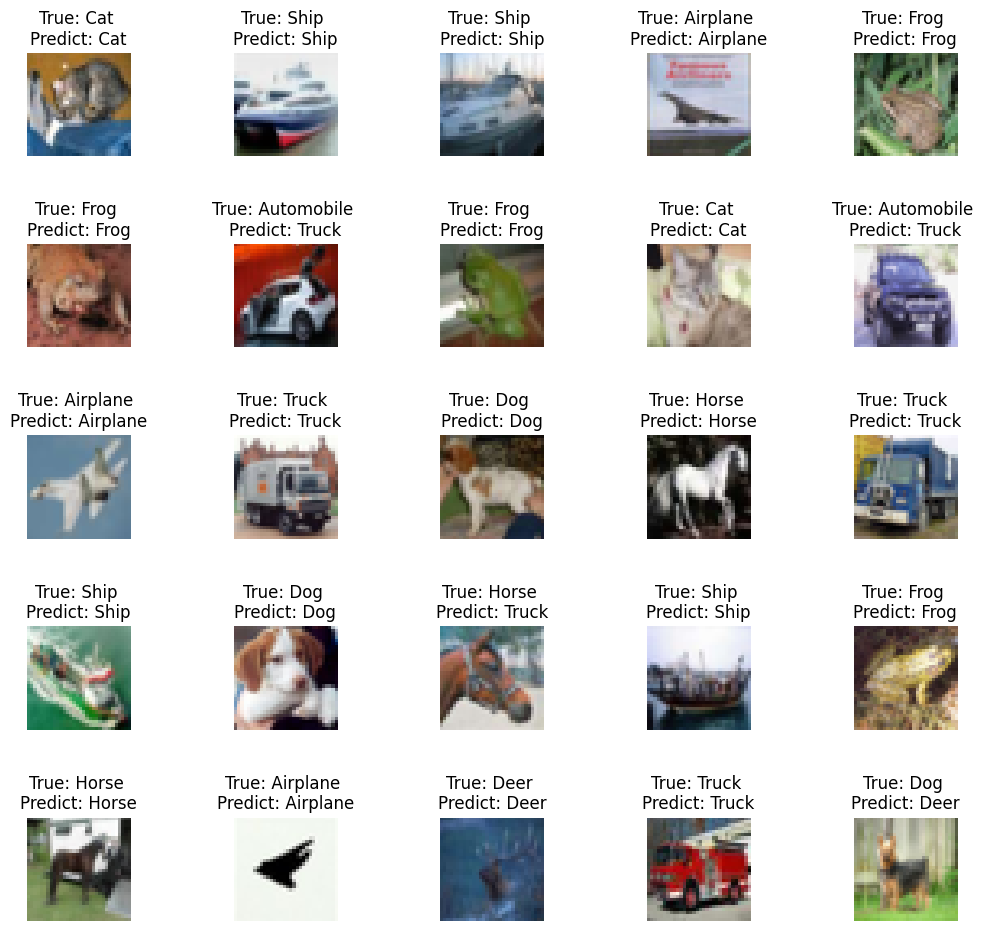

In [ ]:
fig, axes = plt.subplots(5, 5, figsize=(12,12))
axes = axes.ravel()

for i in np.arange(25):
    axes[i].imshow(X_test[i])
    axes[i].set_title('True: %s \nPredict: %s' % (labels[y_true[i]], labels[y_pred[i]]))
    axes[i].axis('off')
    plt.subplots_adjust(wspace=1)

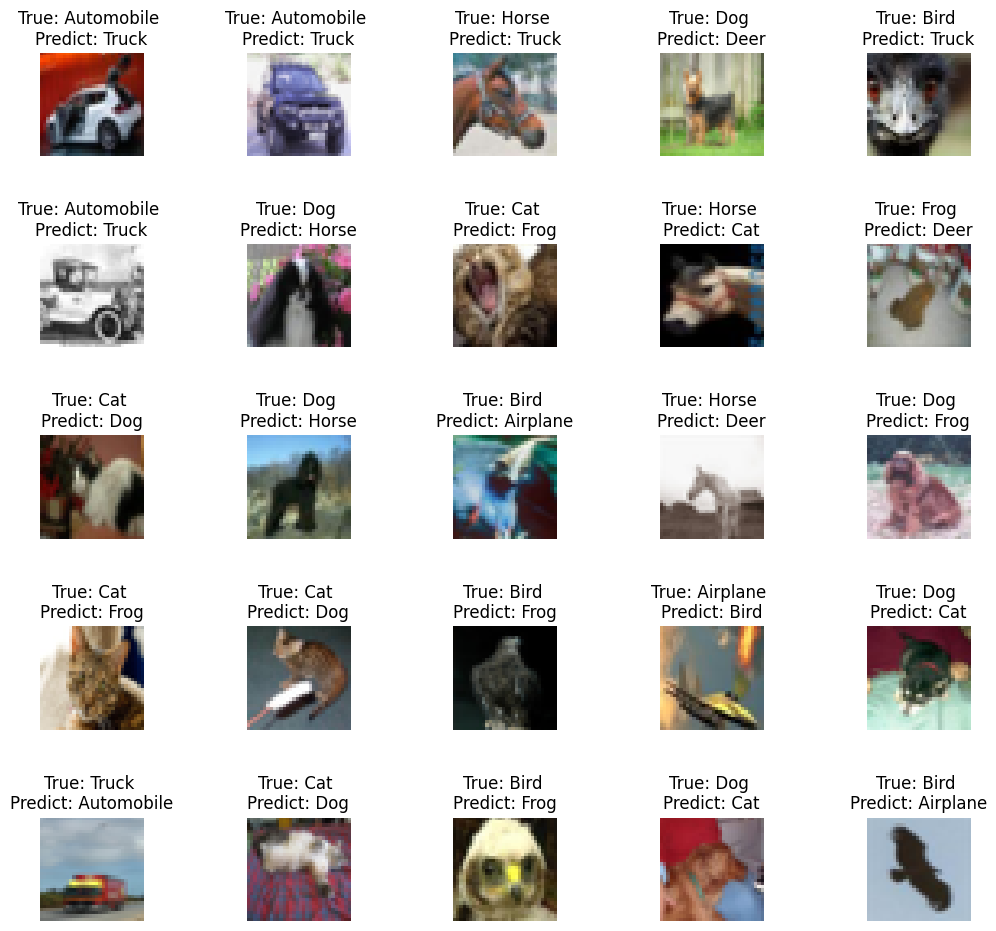

In [ ]:
fig, axes = plt.subplots(5, 5, figsize=(12,12))
axes = axes.ravel()

miss_pred = np.where(y_pred != y_true)[0]
for i in np.arange(25):
    axes[i].imshow(X_test[miss_pred[i]])
    axes[i].set_title('True: %s \nPredict: %s' % (labels[y_true[miss_pred[i]]], labels[y_pred[miss_pred[i]]]))
    axes[i].axis('off')
    plt.subplots_adjust(wspace=1)